In [1]:
import pandas as pd
import seaborn as sns
import itertools
from ggplot import * 
%matplotlib inline

/home/sturm/bin/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/sturm/bin/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/sturm/bin/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
sources = {
    "OribitrapVelos" : "data/OrbitrapVelos_msms.txt",
    "QExactive" : "data/QExactive_msms.txt",
    "TTOF6600" : "data/TTOF6600_msms.txt"
}

### loading and concatenating data

In [3]:
%%time
dfs = []
for name, filename in sources.items(): 
    tmp_df = pd.read_csv(filename, sep='\t')
    tmp_df = tmp_df.assign(source=[name for _ in range(tmp_df.shape[0])])
    dfs.append(tmp_df)
data = pd.concat(dfs)
del dfs

<string>:2: DtypeWarning: Columns (59) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 30.8 s, sys: 1.69 s, total: 32.5 s
Wall time: 32.6 s


### computing seq count

In [4]:
%%time
data.reset_index(inplace = True)
seq_count = data.groupby(['source', 'Sequence']).size().to_frame()
seq_count.reset_index(inplace = True)
seq_count.columns = ["source", "Sequence", "psm_count"]
data = seq_count.merge(data, on = ["source", "Sequence"])

CPU times: user 7.21 s, sys: 675 ms, total: 7.89 s
Wall time: 7.91 s


## 1a) 

CPU times: user 29.9 ms, sys: 115 µs, total: 30 ms
Wall time: 30.2 ms


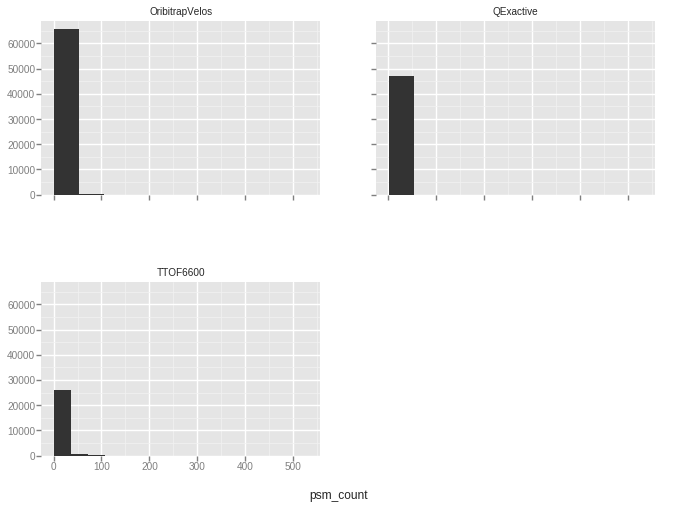

<ggplot: (-9223363276815392263)>

In [5]:
%%time
ggplot(seq_count, aes(x="psm_count")) + geom_histogram() + facet_wrap("source")

## 1b) 

b1

CPU times: user 1.13 s, sys: 131 ms, total: 1.27 s
Wall time: 1.27 s


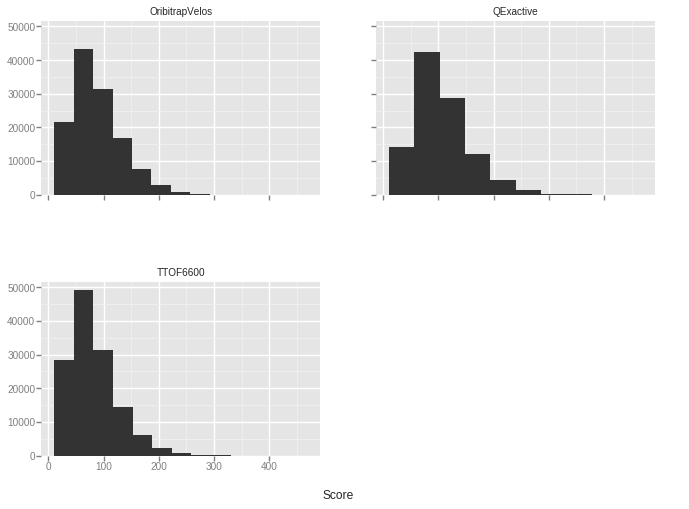

<ggplot: (-9223363276775001891)>

In [6]:
%%time
ggplot(data.loc[data["psm_count"] > 10,:], aes(x="Score")) + geom_histogram() + facet_wrap("source")

b2

CPU times: user 256 ms, sys: 156 ms, total: 412 ms
Wall time: 413 ms


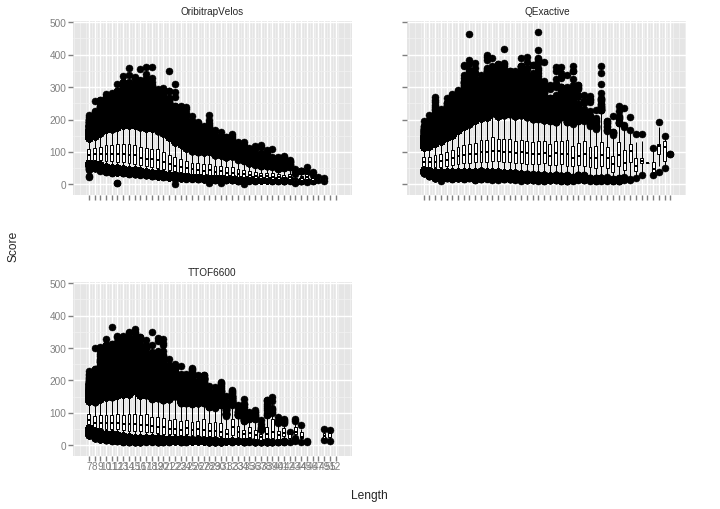

<ggplot: (-9223363276775180351)>

In [7]:
%%time
ggplot(data, aes(y="Score", x = "Length")) + geom_boxplot() + facet_wrap("source")

b3

CPU times: user 256 ms, sys: 136 ms, total: 392 ms
Wall time: 391 ms


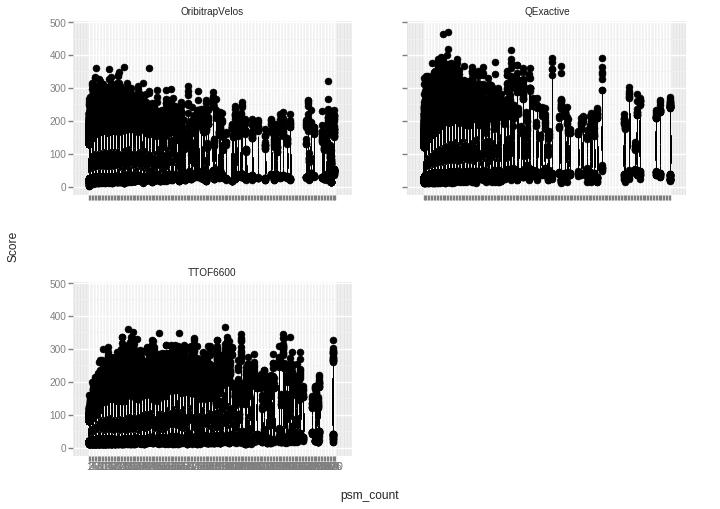

<ggplot: (-9223363276821558240)>

In [8]:
%%time
ggplot(data, aes(y="Score", x = "psm_count")) + geom_boxplot() + facet_wrap("source")

## 1c) 

In [10]:
%%time
def sum_intensities(intensity):
    return sum([float(f) for f in intensity.strip().split(";")])

data = data.assign(intensity = [sum_intensities(x) for x in data.Intensities])

CPU times: user 11 s, sys: 51.4 ms, total: 11.1 s
Wall time: 11.1 s


CPU times: user 289 ms, sys: 257 ms, total: 545 ms
Wall time: 839 ms


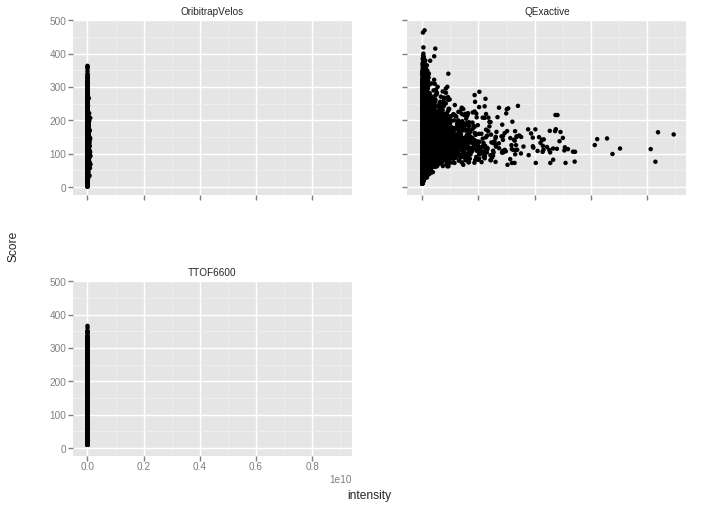

<ggplot: (-9223363276848718262)>

In [11]:
%%time
ggplot(data, aes(x = "intensity", y = "Score")) + geom_point() + facet_wrap("source")

## 1d) 
plot spectra

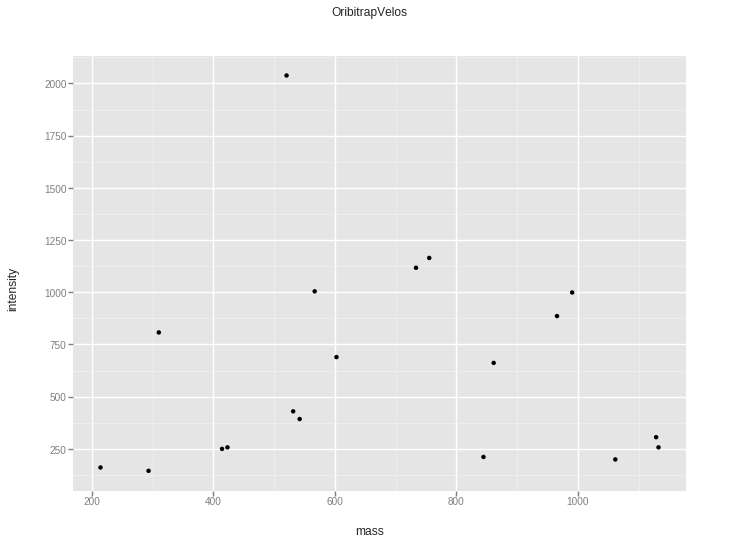

<ggplot: (-9223363276848916792)>


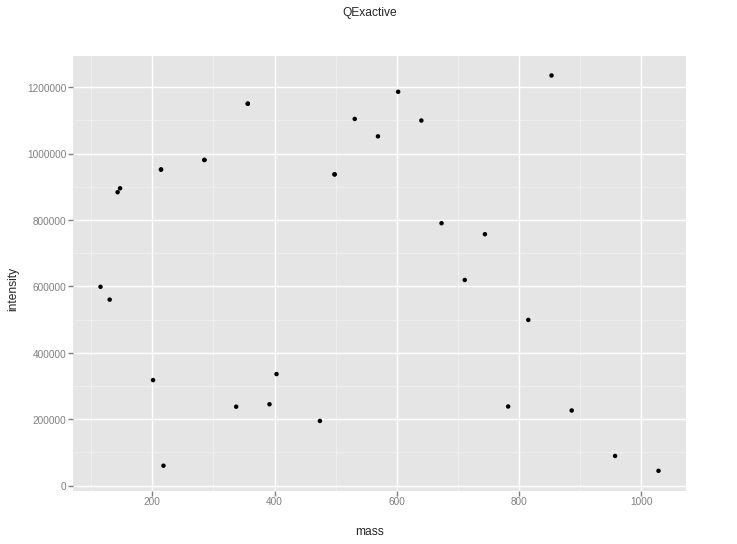

<ggplot: (-9223363276848403617)>


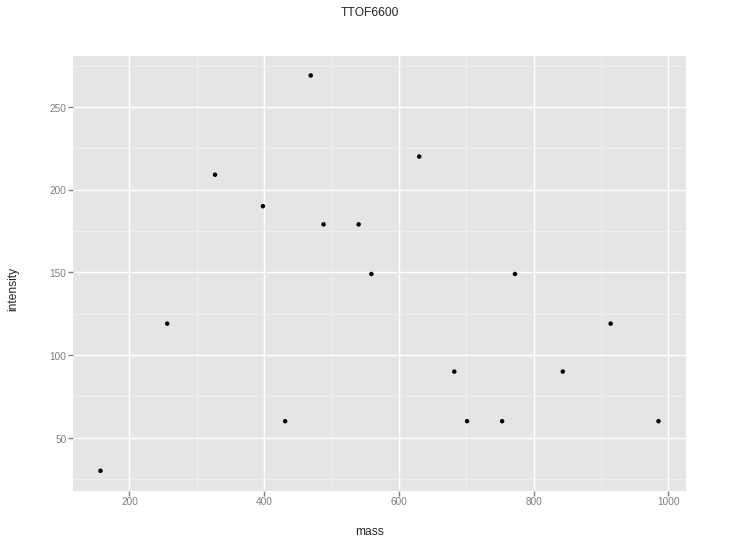

<ggplot: (8760005912573)>
CPU times: user 2.53 s, sys: 1.41 s, total: 3.94 s
Wall time: 2.71 s


In [12]:
%%time
def split_numeric(str_list):
    return [float(f) for f in str_list.strip().split(";")]

for source in sources.keys():
    tmp_dat = data.loc[data.source == source,].iloc[0,]
    spectrum = pd.DataFrame().assign(intensity = split_numeric(tmp_dat.Intensities), 
                                    mass = split_numeric(tmp_dat.Masses))
    print(ggplot(spectrum, aes(x = 'mass', y = "intensity")) + ggtitle(source) + geom_point())

## 1e) search for all b1-ions

In [13]:
%%time
b1_intensities = []
for ions, intensities in zip(data.Matches, data.Intensities):
    for ion, intensity in zip(ions.strip().split(";"), split_numeric(intensities)):
        if ion == "b2":
            b1_intensities.append(intensity)
intensities = pd.DataFrame().assign(intensity = b1_intensities)

CPU times: user 17.8 s, sys: 29.7 ms, total: 17.8 s
Wall time: 17.9 s


CPU times: user 33.3 ms, sys: 445 µs, total: 33.8 ms
Wall time: 36.1 ms


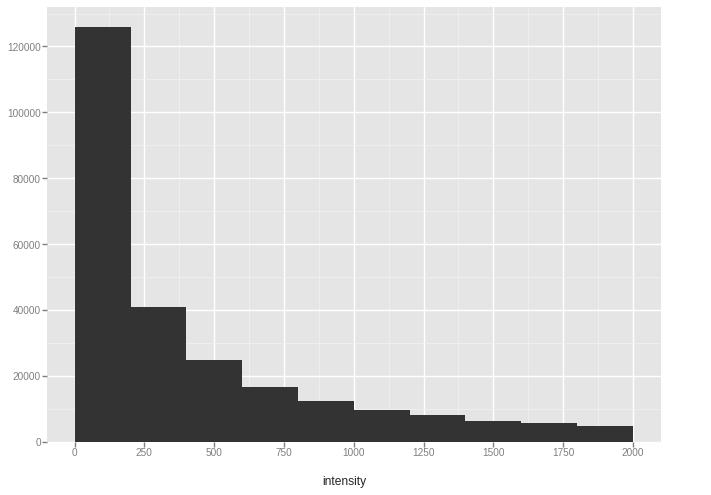

<ggplot: (-9223363276848719854)>

In [14]:
%%time
ggplot(intensities.query("intensity < 2000"), aes(x = "intensity")) + geom_histogram()